In [ ]:
# WARNING EXPLANATION:
# The warning 'You are saving your model as an HDF5 file... This file format is considered legacy. We recommend using instead the native Keras format, e.g. model.save("my_model.keras")' means that Keras now prefers the '.keras' file extension for saving models.
# To resolve this, in cell WUBF39vphGgI, you should change:
# `model.save("emotion_cnn_model.h5")`
# to:
# `model.save("emotion_cnn_model.keras")`

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import nltk
import re

In [ ]:
# Load text data
train_df = pd.read_csv("/train.txt", sep=';', names=['text', 'label'])
val_df   = pd.read_csv("/val.txt", sep=';', names=['text', 'label'])
test_df  = pd.read_csv("/test.txt", sep=';', names=['text', 'label'])

print(train_df.head())
print(train_df['label'].value_counts())


                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text']   = val_df['text'].apply(clean_text)
test_df['clean_text']  = test_df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
val_df['label_encoded']   = le.transform(val_df['label'])
test_df['label_encoded']  = le.transform(test_df['label'])

num_classes = len(le.classes_)
print("Emotion classes:", le.classes_)


Emotion classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['clean_text'])

def prep_sequences(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=100, padding='post', truncating='post')

X_train = prep_sequences(train_df['clean_text'])
X_val   = prep_sequences(val_df['clean_text'])
X_test  = prep_sequences(test_df['clean_text'])

y_train = to_categorical(train_df['label_encoded'], num_classes=num_classes)
y_val   = to_categorical(val_df['label_encoded'], num_classes=num_classes)
y_test  = to_categorical(test_df['label_encoded'], num_classes=num_classes)


In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.4901 - loss: 1.2707 - val_accuracy: 0.9170 - val_loss: 0.2082
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.9454 - loss: 0.1529 - val_accuracy: 0.9205 - val_loss: 0.2010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.9749 - loss: 0.0701 - val_accuracy: 0.9240 - val_loss: 0.2052
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.9864 - loss: 0.0408 - val_accuracy: 0.9260 - val_loss: 0.2209
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/step - accuracy: 0.9903 - loss: 0.0294 - val_accuracy: 0.9245 - val_loss: 0.2523
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9937 - loss: 0.0202 - val_accuracy: 0.9240 - val_loss: 0.2608
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.9937 - loss: 0.0200 - val_accuracy: 0.9305 - val_loss: 0.2883
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9926 - loss: 0.0219 - 

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9089 - loss: 0.3639
Test Accuracy: 91.35%


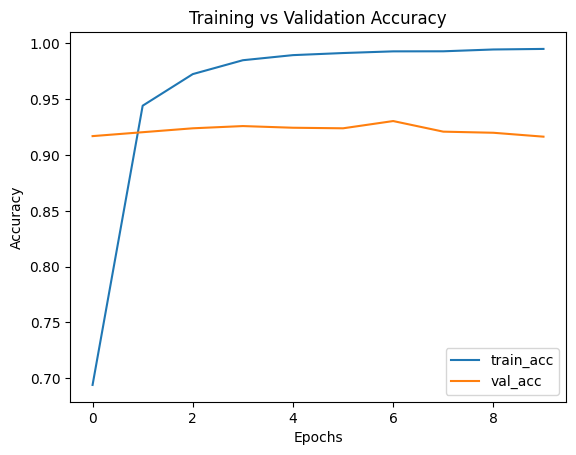

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


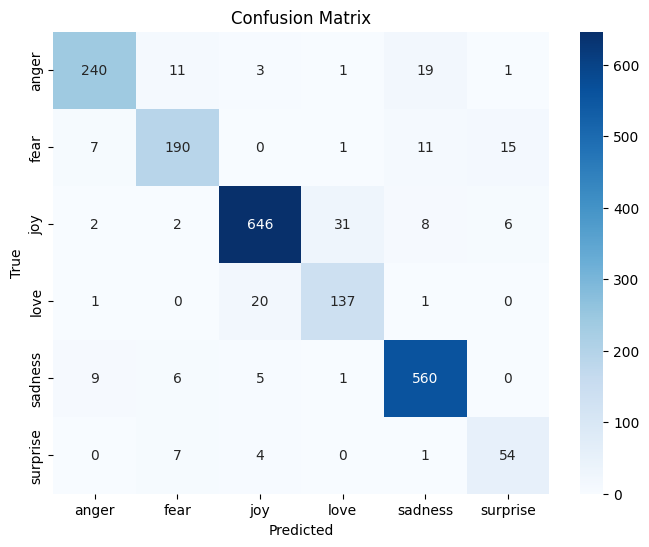

              precision    recall  f1-score   support

       anger       0.93      0.87      0.90       275
        fear       0.88      0.85      0.86       224
         joy       0.95      0.93      0.94       695
        love       0.80      0.86      0.83       159
     sadness       0.93      0.96      0.95       581
    surprise       0.71      0.82      0.76        66

    accuracy                           0.91      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.92      0.91      0.91      2000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=le.classes_))


In [ ]:
def predict_emotion(text):
    # --- Clean the text (same as training preprocessing) ---
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # --- Convert to sequence and pad ---
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')

    # --- Predict emotion ---
    pred = model.predict(padded)
    emotion = le.classes_[np.argmax(pred)]
    confidence = np.max(pred)

    print(f"Predicted Emotion: {emotion} (Confidence: {confidence:.2f})")
    return emotion

# Example usage:
user_input = input("Enter a sentence to analyze emotion: ")
predict_emotion(user_input)


Enter a sentence to analyze emotion: i am very angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Emotion: anger (Confidence: 0.96)


'anger'

In [ ]:
model.save("emotion_cnn_model.keras")


1) Description of the problem
The primary goal of this project is to classify emotions from textual data. Given a piece of text (e.g., a sentence or short phrase), the model aims to predict the underlying emotion expressed within that text. This is a multi-class text classification problem.

2) Dataset and its description
The project uses three distinct datasets for training, validation, and testing:

train.txt: For training the model.
val.txt: For validating the model's performance during training.
test.txt: For evaluating the final trained model's performance on unseen data.
Each dataset is a CSV-like file with two columns:

text: Contains the raw textual input.
label: The corresponding emotion category for the text.
The emotion categories (labels) identified in the dataset are: 'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'. The train_df shows the distribution of these labels: * joy: 5362 samples * sadness: 4666 samples * anger: 2159 samples * fear: 1937 samples * love: 1304 samples * surprise: 572 samples

3) Your approach to solve the problem
The approach taken involves a standard pipeline for deep learning-based text classification:

Data Preprocessing:

Text is converted to lowercase.
URLs and non-alphabetic characters are removed using regular expressions.
English stopwords (common words like 'the', 'is', 'a') are removed using nltk.corpus.stopwords to focus on more meaningful words.
Label Encoding: Categorical emotion labels are converted into numerical representations using LabelEncoder and then one-hot encoded using to_categorical for the model's output layer.
Text Vectorization: The Tokenizer from tf.keras.preprocessing.text is used to convert text into sequences of integers. An Out-Of-Vocabulary (<OOV>) token handles words not seen during training. Sequences are then padded to a fixed length (100) using pad_sequences for uniform input to the neural network.
Model Architecture: A Convolutional Neural Network (CNN) is employed for emotion classification. The model consists of:

Embedding Layer: Maps each word index to a dense vector of fixed size (128 dimensions), learning word representations.
Conv1D Layer: Applies 1D convolution (128 filters, kernel size 5) over the embedded sequences, capturing local patterns (n-grams) in the text.
GlobalMaxPooling1D Layer: Reduces the output of the convolutional layer to a single feature vector by taking the maximum value across all time steps, thus capturing the most salient features.
Dense Layer: A fully connected layer with 64 units and ReLU activation for learning higher-level features.
Dropout Layer: A dropout rate of 0.3 is applied to prevent overfitting by randomly setting a fraction of input units to zero during training.
Output Dense Layer: A final fully connected layer with num_classes (6 in this case) units and a softmax activation function, outputting the probability distribution over the emotion classes.
Model Compilation and Training:

The model is compiled with categorical_crossentropy as the loss function (suitable for multi-class classification with one-hot encoded labels) and the adam optimizer.
It is trained for 10 epochs with a batch size of 32, using the validation data to monitor performance.
Model Evaluation:

The model's performance is evaluated on the test set (X_test, y_test) to calculate overall accuracy and loss.
A Confusion Matrix is generated to visualize the model's performance across individual emotion classes, showing correct and incorrect predictions.
A Classification Report provides precision, recall, and F1-score for each class, offering a detailed breakdown of the model's predictive capability per emotion.
4) Appropriate references for your findings or arguments
The methodologies used in this project are based on well-established concepts in Natural Language Processing (NLP) and Deep Learning:

Convolutional Neural Networks (CNNs) for Text Classification: The use of 1D CNNs for extracting features from text is a common and effective technique, popularized by works like Kim (2014) on applying CNNs to sentence classification.
Word Embeddings: The embedding layer is fundamental to modern NLP, representing words in a dense vector space, often influenced by works like Word2Vec (Mikolov et al., 2013).
Preprocessing Techniques: Standard text cleaning practices (lowercasing, punctuation removal, stopword removal) are widely documented in NLP literature.
Keras/TensorFlow: The implementation leverages the Keras API, a high-level neural networks API, which simplifies the construction and training of deep learning models.
Scikit-learn: Libraries like LabelEncoder for data transformation are standard tools in machine learning workflows.
NLTK (Natural Language Toolkit): For linguistic processing tasks like stopword removal.
While no specific research papers were cited directly in the notebook cells, the architectural choices and preprocessing steps align with best practices and common findings in the field of deep learning for NLP.



In [ ]:
import pickle

# Save Tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save LabelEncoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
